## Import

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 51
TIMESTEPS = 1
DATASET_LINK = "3976184250-1655049260-stripped.csv"
TEST_DATA_LINK = "3976184250-1655049260-test.csv"

# random seed for reproducibility
SEED = 123

### LOAD MODEL

In [84]:
# ##################
# # # load model # #
# ##################

# model = create_model()
model = load_model("model/lstm_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [85]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df['Subject'] = pred_df['Subject'].str.replace('@yopmail.com','')
pred_df['Subject'] = pred_df['Subject'].str.replace('@gmail.com','')
pred_df['Subject'] = pred_df['Subject'].str.replace('alithnks','ali')

column_to_reorder = pred_df.pop('Subject')

pred_df.insert(0, 'Subject', column_to_reorder)
pred_df.head()

,Subject,__id__,AvA,AvH,AvP,`DD.0.5`,`DD.1.6`,`DD.2.4`,`DD.4.8`,`DD.5.2`,...,`Size.9`,`UD.0.5`,`UD.1.6`,`UD.2.4`,`UD.4.8`,`UD.5.2`,`UD.6.7`,`UD.7.9`,`UD.8.1`,`UD.9.3`
0,aisha,32EyOh61auQrtt845qqu,30.386073,0.117320,0.207566,0.316371,0.525669,0.183837,0.574917,1.299633,...,29.588976,0.316371,0.525669,0.183837,0.574917,1.299633,0.333369,1.700769,0.949691,0.607718
1,aisha,4bA0GNx1E4csaTigdnUk,29.442656,0.117420,0.212496,0.349458,3.484031,0.219371,0.813483,0.342324,...,24.210612,0.349458,3.484031,0.219371,0.813483,0.342324,0.608039,0.625773,0.416927,0.908202
2,aisha,8XMHJ2b4PLrT9XU667dv,29.863961,0.098838,0.219027,0.282859,0.284138,0.192723,0.191222,0.224901,...,28.748535,0.282859,0.284138,0.192723,0.191222,0.224901,0.232967,0.466518,0.207866,0.426501
3,ali,x1FEHtJP9xDxTOeMGxGD,29.888982,0.088453,0.324981,0.267652,0.215470,0.123510,0.207815,0.200449,...,27.667969,0.267652,0.215470,0.123510,0.207815,0.200449,0.117066,0.200477,0.143154,0.207918
4,ali,y5GzBnwpg43QOeOzQ28R,27.805260,0.077486,0.211683,0.233024,0.932978,0.163148,0.449982,0.194738,...,27.667969,0.233024,0.932978,0.163148,0.449982,0.194738,0.165819,0.199959,0.192599,0.201954


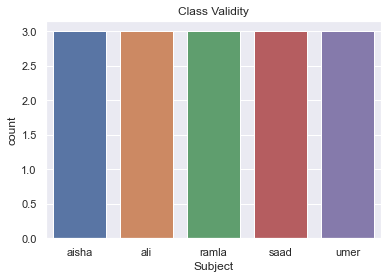

In [86]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [93]:
pred_dataset = pred_df.values

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[:,3:]

# print(pred_row)
############################
# # predict a single row # #
############################

pred_row=pred_df.iloc[:12,2:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
# pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = ['aisha', 'ramla', 'umer', 'alithnks', 'saad']
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

In [94]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)
pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

1/1 [==============================] - 0s 17ms/step
   Prediction    Accuracy
0       aisha   0.6969647
1       aisha  0.92415464
2       aisha  0.64750534
3    alithnks  0.91037625
4    alithnks    0.905103
5    alithnks  0.90502083
6       ramla  0.99574786
7       ramla  0.95465946
8       ramla   0.9844536
9        saad    0.997033
10       saad  0.99771357
11       saad   0.9295934
